# Preprocessing, Feature Extraction and Modelling

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from skimage import feature
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
from skimage import io, color, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

## Preprocessing

In [4]:
# Path directory containing the "CORROSION" and "NOCORROSION" folders
root_dir = './data'
output_dir = './resize_data'

# Define the target size
target_size = (256, 256)

# Function to resize and add padding to an image
def resize_and_add_padding(image_path, output_path):
    image = Image.open(image_path)
    image = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
    image.save(output_path)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through the "CORROSION" and "NOCORROSION" folders
for class_folder in ['CORROSION', 'NOCORROSION']:
    class_dir = os.path.join(root_dir, class_folder)

    # Create a subdirectory in the output directory for each class
    class_output_dir = os.path.join(output_dir, class_folder)
    os.makedirs(class_output_dir, exist_ok=True)

    # Iterate through the images in the class folder
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg'):  # Adjust the file extension as needed
            input_image_path = os.path.join(class_dir, filename)
            output_image_path = os.path.join(class_output_dir, filename)
            resize_and_add_padding(input_image_path, output_image_path)
            print(f"Resized: {input_image_path} -> {output_image_path}")


FileNotFoundError: [Errno 2] No such file or directory: './data/CORROSION'

## Feature Extraction

### Gray Level Co-Occurance Matrix

In [ ]:
def compute_glcm_features(image_path):
    img = io.imread(image_path)
    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])  # 16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max() + 1
    matrix_cooccurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    contrast = graycoprops(matrix_cooccurrence, 'contrast')
    dissimilarity = graycoprops(matrix_cooccurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_cooccurrence, 'homogeneity')
    energy = graycoprops(matrix_cooccurrence, 'energy')
    correlation = graycoprops(matrix_cooccurrence, 'correlation')
    asm = graycoprops(matrix_cooccurrence, 'ASM')

    return {
        "Contrast": contrast,
        "Dissimilarity": dissimilarity,
        "Homogeneity": homogeneity,
        "Energy": energy,
        "Correlation": correlation,
        "ASM": asm
    }

In [ ]:
corrosion_dir = "resize_data/CORROSION"
nocorrosion_dir = "resize_data/NOCORROSION"

# Function to compute GLCM features for a directory of images
def compute_glcm_features_for_directory(directory, label):
    features_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            features = compute_glcm_features(image_path)
            features["Label"] = label  # Add the label
            features_list.append(features)
    return features_list

# Compute GLCM features for both classes
corrosion_features = compute_glcm_features_for_directory(corrosion_dir, "corrosion")
nocorrosion_features = compute_glcm_features_for_directory(nocorrosion_dir, "nocorrosion")

# Combine features for both classes
all_features = corrosion_features + nocorrosion_features
feature_df = pd.DataFrame(all_features)

# Save the DataFrame to a CSV file
feature_df.to_csv("./features/glcm_features.csv", index=False)


In [ ]:
def extract_and_split(df, column_name, new_column_names):
    # Extract the column and remove square brackets
    df[column_name] = df[column_name].str.replace('[', '').str.replace(']', '')
    
    # Split the column values by whitespace and expand them into separate columns
    df[new_column_names] = df[column_name].str.split(expand=True)
    df.drop(columns=[column_name], inplace=True)


df_data = pd.read_csv('./features/glcm_features.csv')


columns_to_process = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']
new_column_sets = [['Contrast0', 'Contrast45', 'Contrast90', 'Contrast135'],
                   ['Dissimilarity0', 'Dissimilarity45', 'Dissimilarity90', 'Dissimilarity135'],
                   ['Homogeneity0', 'Homogeneity45', 'Homogeneity90', 'Homogeneity135'],
                   ['Energy0', 'Energy45', 'Energy90', 'Energy135'],
                   ['Correlation0', 'Correlation45', 'Correlation90', 'Correlation135'],
                   ['ASM0', 'ASM45', 'ASM90', 'ASM135']]

# Apply the extraction and splitting function to each set of columns
for column, new_columns in zip(columns_to_process, new_column_sets):
    extract_and_split(df_data, column, new_columns)


new_csv_filename = './features/glcm_features_split.csv'
df_data.to_csv(new_csv_filename, index=False)

Accuracy: 0.6256983240223464, pca_component = 1
Accuracy: 0.6256983240223464, pca_component = 2
Accuracy: 0.6787709497206704, pca_component = 3
Accuracy: 0.7374301675977654, pca_component = 4


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7402234636871509, pca_component = 5


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.770949720670391, pca_component = 6


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7513966480446927, pca_component = 7


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7681564245810056, pca_component = 8


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7737430167597765, pca_component = 9


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7737430167597765, pca_component = 10


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7681564245810056, pca_component = 11


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.770949720670391, pca_component = 12


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7821229050279329, pca_component = 13


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7849162011173184, pca_component = 14


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7988826815642458, pca_component = 15
Classification Report:
              precision    recall  f1-score   support

   corrosion       0.81      0.82      0.81       192
 nocorrosion       0.79      0.77      0.78       166

    accuracy                           0.80       358
   macro avg       0.80      0.80      0.80       358
weighted avg       0.80      0.80      0.80       358

Test Accuracy: 79.89%


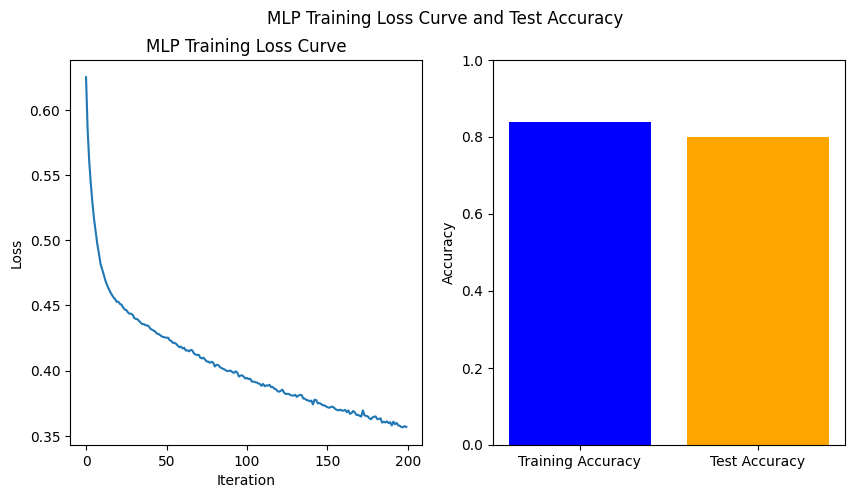

In [16]:
data = pd.read_csv('./features/glcm_features_split.csv')

features = data.drop('Label', axis=1)

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

n_components = 15

for i in range(n_components):

    pca = PCA(n_components=i+1)
    pca.fit(features_standardized)

    # Transform the features
    features_pca = pca.transform(features_standardized)


    # Encode labels
    label_encoder = LabelEncoder()
    y = data['Label']
    y = label_encoder.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_pca, y, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, ), max_iter=200, random_state=42, verbose=False, solver='adam',alpha=0.0001,
                                activation='relu', learning_rate='constant', )
    mlp_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = mlp_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    # Print the results
    print(f"Accuracy: {accuracy}, pca_component = {i+1}")

print(f"Classification Report:\n{classification_rep}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot the loss and accuracy curves during training
plt.figure(figsize=(10, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(mlp_classifier.loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Bar chart for accuracy
plt.subplot(1, 2, 2)
labels = ['Training Accuracy', 'Test Accuracy']
accuracy_values = [mlp_classifier.score(X_train, y_train), mlp_classifier.score(X_test, y_test)]
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.suptitle('MLP Training Loss Curve and Test Accuracy')

plt.savefig('mlp_training_curve.png')

plt.show()

#### Saving The Model

In [ ]:
# Save the trained MLP classifier to a file
model_filename = './model/mlp_classifier_model.joblib'
joblib.dump(mlp_classifier, model_filename)

['./model/mlp_classifier_model.joblib']

#### Main Code Prediction

In [ ]:
model_filename = './model/mlp_classifier_model.joblib'
loaded_mlp_classifier = joblib.load(model_filename)

image_path = './resize_data/NOCORROSION/100e35cf19.jpg'
target_size = (256, 256)

image = Image.open(image_path)

# Resize Image
image_new = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
temp_image_path = './temp_resized_image.jpg'
image_new.save(temp_image_path)

# Extract GLCM Value
features = compute_glcm_features(temp_image_path)

# Initialize a new dictionary to store the transformed features
transformed_features = {}

# Define a list of angles
angles = ['0', '45', '90', '135']

# Iterate through the features and angles to create new labels
for feature_name, feature_values in features.items():
    for i, angle in enumerate(angles):
        new_label = f'{feature_name}{angle}'
        transformed_features[new_label] = feature_values[0][i]

# Transform the dictionary to a 1D NumPy array
transformed_features_array = np.array(list(transformed_features.values())).reshape(1, -1)

# Make predictions using the loaded model
predictions = loaded_mlp_classifier.predict(transformed_features_array)

if predictions[0] == 0:
    print("HASIL PREDIKSI: Corrosion")
else:
    print("HASIL PREDIKSI: NoCorrosion")

# Close and remove the temporary image file
image_new.close()
if os.path.exists(temp_image_path):
    os.remove(temp_image_path)

image = plt.imread(image_path)
plt.imshow(image)

ValueError: X has 24 features, but MLPClassifier is expecting 15 features as input.

### Local Binary Pattern

In [ ]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' folder structure
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1790, 256, 256)
(1432, 256, 256)
(358, 256, 256)
(1432,)
(358,)


In [ ]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


In [ ]:
X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
classify_report = classification_report(y_test, y_pred)


print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Overall Accuracy: {accuracy}")
print(f"Overall Accuracy: {classify_report}")

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.9636871508379888
Test Accuracy: 0.8491620111731844
Precision: 0.8502792586951002
Recall: 0.8463227911646587
F1 Score: 0.8476211495412556
Overall Accuracy: 0.8491620111731844
Overall Accuracy:               precision    recall  f1-score   support

           0       0.84      0.89      0.86       192
           1       0.86      0.81      0.83       166

    accuracy                           0.85       358
   macro avg       0.85      0.85      0.85       358
weighted avg       0.85      0.85      0.85       358



In [ ]:
# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


In [ ]:
def lbp_texture(image):
    # Perform LBP feature extraction on a single image
    lbp = feature.local_binary_pattern(image, n_point, radius, 'default')
    max_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=max_bins, density=True)
    return hist

# Load and preprocess a single image
image_path = './resize_data/NOCORROSION/01a5aee1ab.jpg'
im = Image.open(image_path).convert('L')
data = np.array(im)

# Define LBP parameters
radius = 2
n_point = radius * 8

# Call the LBP function on the single image
lbp_features = lbp_texture(data)

loaded_model = joblib.load('model/mlp_lbp_model.pkl')
prediction = loaded_model.predict([lbp_features])
print(prediction)


FileNotFoundError: [Errno 2] No such file or directory: 'model/mlp_lbp_model.pkl'

### Gray Level Run Length Matrix

In [ ]:
class getGrayRumatrix:
    data = 0 
    def read_img(self,path=" "):
        
        try:
            img = Image.open(path) 
            img = img.convert('L')
            self.data=np.array(img)
            
        except:
            img = None
            
    def getGrayLevelRumatrix(self, array, theta):
            '''
            
            array: the numpy array of the image
            theta: Input, the angle used when calculating the gray scale run matrix, list type, can contain fields:['deg0', 'deg45', 'deg90', 'deg135']
            glrlm: output,the glrlm result
            '''
            P = array
            x, y = P.shape
            min_pixels = np.min(P)   # the min pixel
            run_length = max(x, y)   # Maximum parade length in pixels
            num_level = np.max(P) - np.min(P) + 1   # Image gray level
    
            deg0 = [val.tolist() for sublist in np.vsplit(P, x) for val in sublist]   # 0deg
            deg90 = [val.tolist() for sublist in np.split(np.transpose(P), y) for val in sublist]   # 90deg
            diags = [P[::-1, :].diagonal(i) for i in range(-P.shape[0]+1, P.shape[1])]   #45deg
            deg45 = [n.tolist() for n in diags]
            Pt = np.rot90(P, 3)   # 135deg
            diags = [Pt[::-1, :].diagonal(i) for i in range(-Pt.shape[0]+1, Pt.shape[1])]
            deg135 = [n.tolist() for n in diags]
    
            def length(l):
                if hasattr(l, '__len__'):
                    return np.size(l)
                else:
                    i = 0
                    for _ in l:
                        i += 1
                    return i
    
            glrlm = np.zeros((num_level, run_length, len(theta)))   
            for angle in theta:
                for splitvec in range(0, len(eval(angle))):
                    flattened = eval(angle)[splitvec]
                    answer = []
                    for key, iter in groupby(flattened):  
                        answer.append((key, length(iter)))   
                    for ansIndex in range(0, len(answer)):
                        glrlm[int(answer[ansIndex][0]-min_pixels), int(answer[ansIndex][1]-1), theta.index(angle)] += 1   
            return glrlm
            
    def apply_over_degree(self,function, x1, x2):
        rows, cols, nums = x1.shape
        result = np.ndarray((rows, cols, nums))
        for i in range(nums):
                #print(x1[:, :, i])
                result[:, :, i] = function(x1[:, :, i], x2)
               # print(result[:, :, i])
                result[result == np.inf] = 0
                result[np.isnan(result)] = 0
        return result 
    def calcuteIJ (self,rlmatrix):
        gray_level, run_length, _ = rlmatrix.shape
        I, J = np.ogrid[0:gray_level, 0:run_length]
        return I, J+1

    def calcuteS(self,rlmatrix):
        return np.apply_over_axes(np.sum, rlmatrix, axes=(0, 1))[0, 0]

    #1.SRE
    def getShortRunEmphasis(self,rlmatrix):
            I, J = self.calcuteIJ(rlmatrix)
            numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (J*J)), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S
    #2.LRE
    def getLongRunEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    #3.GLN
    def getGrayLevelNonUniformity(self,rlmatrix):
        G = np.apply_over_axes(np.sum, rlmatrix, axes=1)
        numerator = np.apply_over_axes(np.sum, (G*G), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    # 4. RLN
    def getRunLengthNonUniformity(self,rlmatrix):
            R = np.apply_over_axes(np.sum, rlmatrix, axes=0)
            numerator = np.apply_over_axes(np.sum, (R*R), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S

        # 5. RP
    def getRunPercentage(self,rlmatrix):
            gray_level, run_length,_ = rlmatrix.shape
            num_voxels = gray_level * run_length
            return self.calcuteS(rlmatrix) / num_voxels

        # 6. LGLRE
    def getLowGrayLevelRunEmphasis(self,rlmatrix):
            I, J = self.calcuteIJ(rlmatrix)
            numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (I*I)), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S

        # 7. HGL   
    def getHighGrayLevelRunEmphais(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (I*I)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S

        # 8. SRLGLE
    def getShortRunLowGrayLevelEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    # 9. SRHGLE
    def getShortRunHighGrayLevelEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        temp = self.apply_over_degree(np.multiply, rlmatrix, (I*I))
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, temp, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
 
    # 10. LRLGLE
    def getLongRunLow(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        temp = self.apply_over_degree(np.multiply, rlmatrix, (J*J))
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, temp, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
 
    # 11. LRHGLE
    def getLongRunHighGrayLevelEmphais(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S

In [ ]:
glr_matrix_calculator = getGrayRumatrix()
glr_matrix_calculator.read_img("./resize_data/CORROSION/000001.jpg")

theta = ['deg0', 'deg45', 'deg90', 'deg135']
glrlm_result = glr_matrix_calculator.getGrayLevelRumatrix(glr_matrix_calculator.data, theta)


In [ ]:
import os
import csv

root_dir = "./resize_data"
subdirectories = ["CORROSION", "NOCORROSION"]

header = ["Label", "SRE", "LRE", "GLN", "RLN", "RP", "LGLRE", "HGL", "SRLGLE", "SRHGLE", "LRLGLE", "LRHGLE"]

with open("./features/glrlm_image_features.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

for label, subdirectory in enumerate(subdirectories):
    subdir_path = os.path.join(root_dir, subdirectory)

    for filename in os.listdir(subdir_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(subdir_path, filename)

            # Read image and calculate GLRLM
            glr_matrix_calculator.read_img(image_path)
            theta = ['deg0', 'deg45', 'deg90', 'deg135']
            glrlm_result = glr_matrix_calculator.getGrayLevelRumatrix(glr_matrix_calculator.data, theta)

            # Calculate features
            sre_result = glr_matrix_calculator.getShortRunEmphasis(glrlm_result)
            lre_result = glr_matrix_calculator.getLongRunEmphasis(glrlm_result)
            gln_result = glr_matrix_calculator.getGrayLevelNonUniformity(glrlm_result)
            rln_result = glr_matrix_calculator.getRunLengthNonUniformity(glrlm_result)
            rp_result = glr_matrix_calculator.getRunPercentage(glrlm_result)
            lglre_result = glr_matrix_calculator.getLowGrayLevelRunEmphasis(glrlm_result)
            hgl_result = glr_matrix_calculator.getHighGrayLevelRunEmphais(glrlm_result)
            srlgle_result = glr_matrix_calculator.getShortRunLowGrayLevelEmphasis(glrlm_result)
            srhgle_result = glr_matrix_calculator.getShortRunHighGrayLevelEmphasis(glrlm_result)
            lrlgle_result = glr_matrix_calculator.getLongRunLow(glrlm_result)
            lrhgle_result = glr_matrix_calculator.getLongRunHighGrayLevelEmphais(glrlm_result)

            # Append results to CSV file
            with open("./features/glrlm_image_features.csv", mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([label, sre_result, lre_result, gln_result, rln_result, rp_result, lglre_result,
                                hgl_result, srlgle_result, srhgle_result, lrlgle_result, lrhgle_result])


/tmp/ipykernel_84488/699285923.py:63: RuntimeWarning: divide by zero encountered in divide
  result[:, :, i] = function(x1[:, :, i], x2)
/tmp/ipykernel_84488/699285923.py:63: RuntimeWarning: invalid value encountered in divide
  result[:, :, i] = function(x1[:, :, i], x2)


In [ ]:
import pandas as pd

df_cek = pd.read_csv('./features/glrlm_image_features.csv')

# Extract the 'Contrast' column and remove square brackets
df_cek['SRE'] = df_cek['SRE'].str.replace('[', '').str.replace(']', '')
df_cek['LRE'] = df_cek['LRE'].str.replace('[', '').str.replace(']', '')
df_cek['GLN'] = df_cek['GLN'].str.replace('[', '').str.replace(']', '')
df_cek['RLN'] = df_cek['RLN'].str.replace('[', '').str.replace(']', '')
df_cek['RP'] = df_cek['RP'].str.replace('[', '').str.replace(']', '')
df_cek['LGLRE'] = df_cek['LGLRE'].str.replace('[', '').str.replace(']', '')
df_cek['HGL'] = df_cek['HGL'].str.replace('[', '').str.replace(']', '')
df_cek['SRLGLE'] = df_cek['SRLGLE'].str.replace('[', '').str.replace(']', '')
df_cek['SRHGLE'] = df_cek['SRHGLE'].str.replace('[', '').str.replace(']', '')
df_cek['LRLGLE'] = df_cek['LRLGLE'].str.replace('[', '').str.replace(']', '')
df_cek['LRHGLE'] = df_cek['LRHGLE'].str.replace('[', '').str.replace(']', '')


# Split the 'SRE' column values by whitespace and expand them into separate columns
df_cek[['SRE0', 'SRE45', 'SRE90', 'SRE135']] = df_cek['SRE'].str.split(expand=True)
df_cek[['LRE0', 'LRE45', 'LRE90', 'LRE135']] = df_cek['LRE'].str.split(expand=True)
df_cek[['GLN0', 'GLN45', 'GLN90', 'GLN135']] = df_cek['GLN'].str.split(expand=True)
df_cek[['RLN0', 'RLN45', 'RLN90', 'RLN135']] = df_cek['RLN'].str.split(expand=True)
df_cek[['RP0', 'RP45', 'RP90', 'RP135']] = df_cek['RP'].str.split(expand=True)
df_cek[['LGLRE0', 'LGLRE45', 'LGLRE90', 'LGLRE135']] = df_cek['LGLRE'].str.split(expand=True)
df_cek[['HGL0', 'HGL45', 'HGL90', 'HGL135']] = df_cek['HGL'].str.split(expand=True)
df_cek[['SRLGLE0', 'SRLGLE45', 'SRLGLE90', 'SRLGLE135']] = df_cek['SRLGLE'].str.split(expand=True)
df_cek[['SRHGLE0', 'SRHGLE45', 'SRHGLE90', 'SRHGLE135']] = df_cek['SRHGLE'].str.split(expand=True)
df_cek[['LRLGLE0', 'LRLGLE45', 'LRLGLE90', 'LRLGLE135']] = df_cek['LRLGLE'].str.split(expand=True)
df_cek[['LRHGLE0', 'LRHGLE45', 'LRHGLE90', 'LRHGLE135']] = df_cek['LRHGLE'].str.split(expand=True)



# Drop the original 'Contrast' column
df_cek.drop(columns=['SRE'], inplace=True)
df_cek.drop(columns=['LRE'], inplace=True)
df_cek.drop(columns=['GLN'], inplace=True)
df_cek.drop(columns=['RLN'], inplace=True)
df_cek.drop(columns=['RP'], inplace=True)
df_cek.drop(columns=['LGLRE'], inplace=True)
df_cek.drop(columns=['HGL'], inplace=True)
df_cek.drop(columns=['SRLGLE'], inplace=True)
df_cek.drop(columns=['SRHGLE'], inplace=True)
df_cek.drop(columns=['LRLGLE'], inplace=True)
df_cek.drop(columns=['LRHGLE'], inplace=True)



# Save the new DataFrame to a new CSV file
new_csv_filename = './features/glrlm_features_split.csv'
df_cek.to_csv(new_csv_filename, index=False)

In [ ]:
data = pd.read_csv('./features/glrlm_features_split.csv')

# Extract features and labels
X = data.drop('Label', axis=1)
y = data['Label']

scaler = StandardScaler()
features_standardized = scaler.fit_transform(X)
n_components = 15

for i in range(n_components):
    pca = PCA(n_components=i+1)
    pca.fit(features_standardized)

    # Transform the features
    features_pca = pca.transform(features_standardized)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_pca, y, test_size=0.2, random_state=42)

    # Initialize and train the MLP classifier
    glrlm_mlp_classifier = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=200, random_state=42, activation='relu', verbose=False, solver='adam',
                                         alpha=0.0001 )
    glrlm_mlp_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = glrlm_mlp_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print('n_composition = ',i+1)
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.6983240223463687
n_composition =  1
Accuracy: 0.6899441340782123
n_composition =  2
Accuracy: 0.7094972067039106
n_composition =  3
Accuracy: 0.7011173184357542
n_composition =  4


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.723463687150838
n_composition =  5


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7150837988826816
n_composition =  6


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7067039106145251
n_composition =  7


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7122905027932961
n_composition =  8


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7206703910614525
n_composition =  9


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7458100558659218
n_composition =  10


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.729050279329609
n_composition =  11


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7374301675977654
n_composition =  12


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7402234636871509
n_composition =  13


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7430167597765364
n_composition =  14
Accuracy: 0.7430167597765364
n_composition =  15
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       192
           1       0.75      0.67      0.71       166

    accuracy                           0.74       358
   macro avg       0.74      0.74      0.74       358
weighted avg       0.74      0.74      0.74       358



/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Save the trained MLP classifier to a file
model_filename = './model/glrlm_classifier_model.joblib'
joblib.dump(glrlm_mlp_classifier, model_filename)

['./model/glrlm_classifier_model.joblib']

#### Model Use

### Model Evaluation